# SAE-97 - Nettoyage Dataset Reviews

**Objectif:** Charger, analyser et nettoyer le dataset Reviews

**Input:** `data/raw/yelp_academic_reviews4students.jsonl`

**Output:** `data/cleaned/reviews_clean.parquet`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
print("✅ Imports réussis")

✅ Imports réussis


In [2]:
RAW_DATA_PATH = Path('../data/raw/yelp_academic_reviews4students.jsonl')
CLEANED_DATA_PATH = Path('../data/cleaned/reviews_clean.parquet')
CLEANED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"📂 Chargement: {RAW_DATA_PATH}")
print(f"💾 Sauvegarde: {CLEANED_DATA_PATH}")

📂 Chargement: ..\data\raw\yelp_academic_reviews4students.jsonl
💾 Sauvegarde: ..\data\cleaned\reviews_clean.parquet


In [3]:
print("⏳ Chargement... (1-2 min)")
reviews_df = pd.read_json(RAW_DATA_PATH, lines=True)
print(f"✅ {reviews_df.shape[0]:,} lignes, {reviews_df.shape[1]} colonnes")

⏳ Chargement... (1-2 min)
✅ 1,000,000 lignes, 9 colonnes


In [4]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53
1,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14
2,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48
3,U9-43s8YUl6GWBFCpxUGEw,PAxc0qpqt5c2kA0rjDFFAg,XwepyB7KjJ-XGJf0vKc6Vg,4,0,0,0,Been here a few times to get some shrimp. The...,2013-04-27 01:55:49
4,8T8EGa_4Cj12M6w8vRgUsQ,BqPR1Dp5Rb_QYs9_fz9RiA,prm5wvpp0OHJBlrvTj9uOg,5,0,0,0,This is one fantastic place to eat whether you...,2019-05-15 18:29:25


In [5]:
reviews_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   review_id    1000000 non-null  str           
 1   user_id      1000000 non-null  str           
 2   business_id  1000000 non-null  str           
 3   stars        1000000 non-null  int64         
 4   useful       1000000 non-null  int64         
 5   funny        1000000 non-null  int64         
 6   cool         1000000 non-null  int64         
 7   text         1000000 non-null  str           
 8   date         1000000 non-null  datetime64[ms]
dtypes: datetime64[ms](1), int64(4), str(4)
memory usage: 673.4 MB


In [6]:
missing = pd.DataFrame({
    'Colonne': reviews_df.columns,
    'Manquantes': reviews_df.isnull().sum(),
    'Pct': (reviews_df.isnull().sum() / len(reviews_df) * 100).round(2)
}).sort_values('Pct', ascending=False)
missing[missing['Manquantes'] > 0]

,Colonne,Manquantes,Pct


In [7]:
reviews_clean = reviews_df.copy()
print(f"📋 Initial: {len(reviews_clean):,} lignes")

📋 Initial: 1,000,000 lignes


In [8]:
# Supprimer doublons
dups = reviews_clean.duplicated(subset=['review_id']).sum()
if dups > 0:
    reviews_clean = reviews_clean.drop_duplicates(subset=['review_id'])
    print(f"❌ {dups} doublons supprimés")
else:
    print("✅ Aucun doublon")

✅ Aucun doublon


In [9]:
# Supprimer lignes sans données essentielles
for col in ['review_id', 'text', 'user_id', 'business_id']:
    if col in reviews_clean.columns:
        before = len(reviews_clean)
        reviews_clean = reviews_clean.dropna(subset=[col])
        if before > len(reviews_clean):
            print(f"❌ {before - len(reviews_clean)} sans {col}")

In [10]:
# Nettoyer texte
if 'text' in reviews_clean.columns:
    reviews_clean['text_length'] = reviews_clean['text'].str.len()
    before = len(reviews_clean)
    reviews_clean = reviews_clean[reviews_clean['text_length'] >= 10]
    print(f"❌ {before - len(reviews_clean)} avis trop courts")
    
    reviews_clean['text'] = reviews_clean['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
    print("✅ Texte nettoyé")

❌ 15 avis trop courts
✅ Texte nettoyé


In [11]:
# Valider notes
if 'stars' in reviews_clean.columns:
    before = len(reviews_clean)
    reviews_clean = reviews_clean[(reviews_clean['stars'] >= 1) & (reviews_clean['stars'] <= 5)]
    if before > len(reviews_clean):
        print(f"❌ {before - len(reviews_clean)} notes invalides")
    else:
        print("✅ Notes valides (1-5)")

✅ Notes valides (1-5)


In [12]:
# Convertir dates
if 'date' in reviews_clean.columns:
    reviews_clean['date'] = pd.to_datetime(reviews_clean['date'], errors='coerce')
    invalid = reviews_clean['date'].isnull().sum()
    if invalid > 0:
        reviews_clean = reviews_clean.dropna(subset=['date'])
        print(f"❌ {invalid} dates invalides")
    else:
        print("✅ Dates converties")

✅ Dates converties


In [13]:
print("📊 RÉSUMÉ")
print("=" * 50)
print(f"Initial:    {len(reviews_df):,}")
print(f"Final:      {len(reviews_clean):,}")
print(f"Supprimé:   {len(reviews_df) - len(reviews_clean):,}")
print(f"Conservé:   {(len(reviews_clean) / len(reviews_df) * 100):.2f}%")

📊 RÉSUMÉ
Initial:    1,000,000
Final:      999,985
Supprimé:   15
Conservé:   100.00%


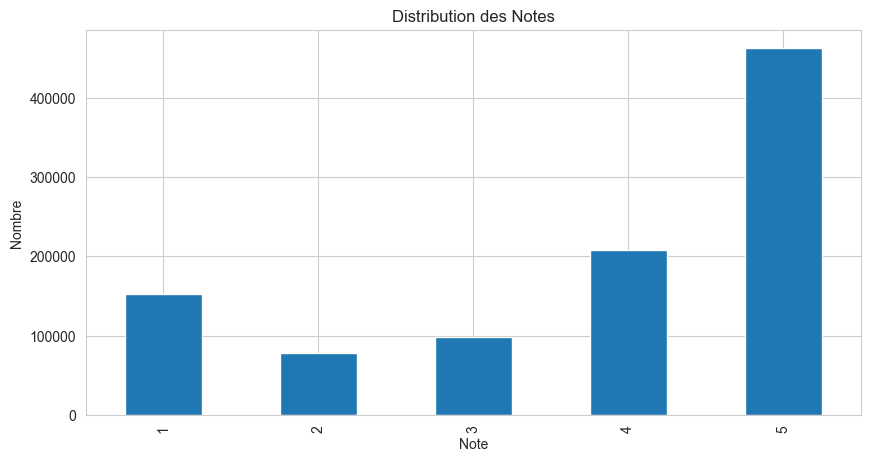

In [14]:
# Distribution notes
if 'stars' in reviews_clean.columns:
    plt.figure(figsize=(10, 5))
    reviews_clean['stars'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Note')
    plt.ylabel('Nombre')
    plt.title('Distribution des Notes')
    plt.show()

In [15]:
# Sauvegarder
if 'text_length' in reviews_clean.columns:
    reviews_clean = reviews_clean.drop(columns=['text_length'])

print("⏳ Sauvegarde...")
reviews_clean.to_parquet(CLEANED_DATA_PATH, index=False, compression='snappy')
print(f"✅ Sauvegardé: {CLEANED_DATA_PATH}")

⏳ Sauvegarde...
✅ Sauvegardé: ..\data\cleaned\reviews_clean.parquet


## ✅ SAE-97 Terminé